Copyright 2021 Twitter, Inc.

SPDX-License-Identifier: Apache-2.0

In [1]:
library(tidyverse)
library(data.table)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
apply_corrections <- function(dat, threshold = FALSE){
  #applies three candidate corrections to the simulated binomial data
  uncorrected_var <- apply(dat$mu_hats, 2, var)
  sigma2_hats <- dat$mu_hats*(1-dat$mu_hats)/dat$nks
  corrected_var <- uncorrected_var - apply(sigma2_hats, 2, mean)
  double_corrected_var <-uncorrected_var - 2*apply(sigma2_hats, 2, mean) + apply(sigma2_hats/dat$nks, 2, mean)
  
  
  
  if(threshold){
    corrected_var <- pmax(0, corrected_var)
    double_corrected_var <- pmax(0, double_corrected_var)
  }
  
  out <- data.frame(uncorrected_var, corrected_var, double_corrected_var)
  
}

double_correction <- function(df, nsample=500) {
    d <- rowwise(df) %>% mutate(sample_rate = list(rbinom(nsample, n, rate)/n))
    results <- apply_corrections(list(mu_hats=do.call(rbind, d$sample_rate), nks=d$n), TRUE)
    bounds <- results %>% summarise_all(~list(as_tibble(as.list(quantile(., probs=c(.025, .975)))))) %>% unnest(cols = 1:3, names_sep='_')
    append(lapply(results, median), bounds)
}

In [3]:
income <- read_csv('adult_income_with_predictions.csv') %>% mutate(age_group = cut_width(age, width=10, center=50))

Rows: 14653 Columns: 15

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): workclass, education, marital-status, occupation, relationship, rac...
dbl (7): age, education-num, capital-gain, capital-loss, hours-per-week, sco...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
nrow(income)

[1] 14653

In [5]:
# mean accuracy
mean(income$income_gt_50K == (income$score >= 0.5))

[1] 0.8727906

In [6]:
summary(income$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.68   48.00   90.00 

In [7]:
income %>% group_by(age_group) %>% summarise(n=n()) %>% ungroup() %>% mutate(prop=n/sum(n))

age_group,n,prop
<fct>,<int>,<dbl>
"[15,25]",2845,0.194158193
"(25,35]",3898,0.266020610
"(35,45]",3515,0.239882618
"(45,55]",2504,0.170886508
"(55,65]",1333,0.090971132
"(65,75]",438,0.029891490
"(75,85]",99,0.006756296
"(85,95]",21,0.001433154


In [8]:
income %>% group_by(race) %>% summarise(count=n()) %>% ungroup() %>% mutate(prop=count/sum(count))

race,count,prop
<chr>,<int>,<dbl>
Amer-Indian-Eskimo,125,0.008530676
Asian-Pac-Islander,401,0.027366410
Black,1347,0.091926568
Other,115,0.007848222
White,12665,0.864328124


In [9]:
df <- list()
for (feature in c('race', 'age_group')) {
    tpr <- income %>% filter(income_gt_50K == 1) %>% group_by(!!as.name(feature)) %>% summarise(rate=mean(score >= 0.5), n=n())
    fpr <- income %>% filter(income_gt_50K == 0) %>% group_by(!!as.name(feature)) %>% summarise(rate=mean(score >= 0.5), n=n())
    sr <- income %>% group_by(!!as.name(feature)) %>% summarise(rate=mean(score >= 0.5), n=n())
     
    df <- append(df, list(c(metric='TPR', feature=feature, double_correction(tpr))))
    df <- append(df, list(c(metric='FPR', feature=feature, double_correction(fpr))))
    df <- append(df, list(c(metric='SR', feature=feature, double_correction(sr))))
}

In [10]:
df <- rbindlist(df, fill=TRUE)

In [11]:
df %>% arrange(metric, feature) %>%
 mutate_if(is.numeric, round, digits=4)

metric,feature,uncorrected_var,corrected_var,double_corrected_var,uncorrected_var_2.5%,uncorrected_var_97.5%,corrected_var_2.5%,corrected_var_97.5%,double_corrected_var_2.5%,double_corrected_var_97.5%
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FPR,age_group,0.0028,0.0021,0.0013,0.0017,0.0116,0.0011,0.0097,0.0003,0.0079
FPR,race,0.0014,0.0012,0.0011,0.0007,0.0025,0.0006,0.0023,0.0005,0.0022
SR,age_group,0.0157,0.0142,0.0128,0.0122,0.0287,0.0110,0.0270,0.0098,0.0255
SR,race,0.0072,0.0068,0.0065,0.0045,0.0108,0.0041,0.0105,0.0037,0.0103
TPR,age_group,0.0286,0.0227,0.0176,0.0118,0.0477,0.0043,0.0455,0.0000,0.0431
TPR,race,0.0155,0.0084,0.0018,0.0028,0.0520,0.0000,0.0463,0.0000,0.0407


In [12]:
pd <- df %>% select(-(3:5)) %>% pivot_longer(cols=3:8, names_sep='_var_', names_to=c("method", "bound")) %>% filter(method != 'corrected') %>% pivot_wider(names_from=bound)
pd <- rename(pd, c('lower'='2.5%', 'upper'='97.5%'))

In [13]:
pd

metric,feature,method,lower,upper
<chr>,<chr>,<chr>,<dbl>,<dbl>
TPR,race,uncorrected,0.0028097355,0.052041650
TPR,race,double_corrected,0.0000000000,0.040719331
FPR,race,uncorrected,0.0007183938,0.002466362
FPR,race,double_corrected,0.0005151764,0.002218034
SR,race,uncorrected,0.0044530790,0.010778322
SR,race,double_corrected,0.0036981694,0.010252778
TPR,age_group,uncorrected,0.0118473758,0.047725370
TPR,age_group,double_corrected,0.0000000000,0.043064355
FPR,age_group,uncorrected,0.0017429443,0.011628342


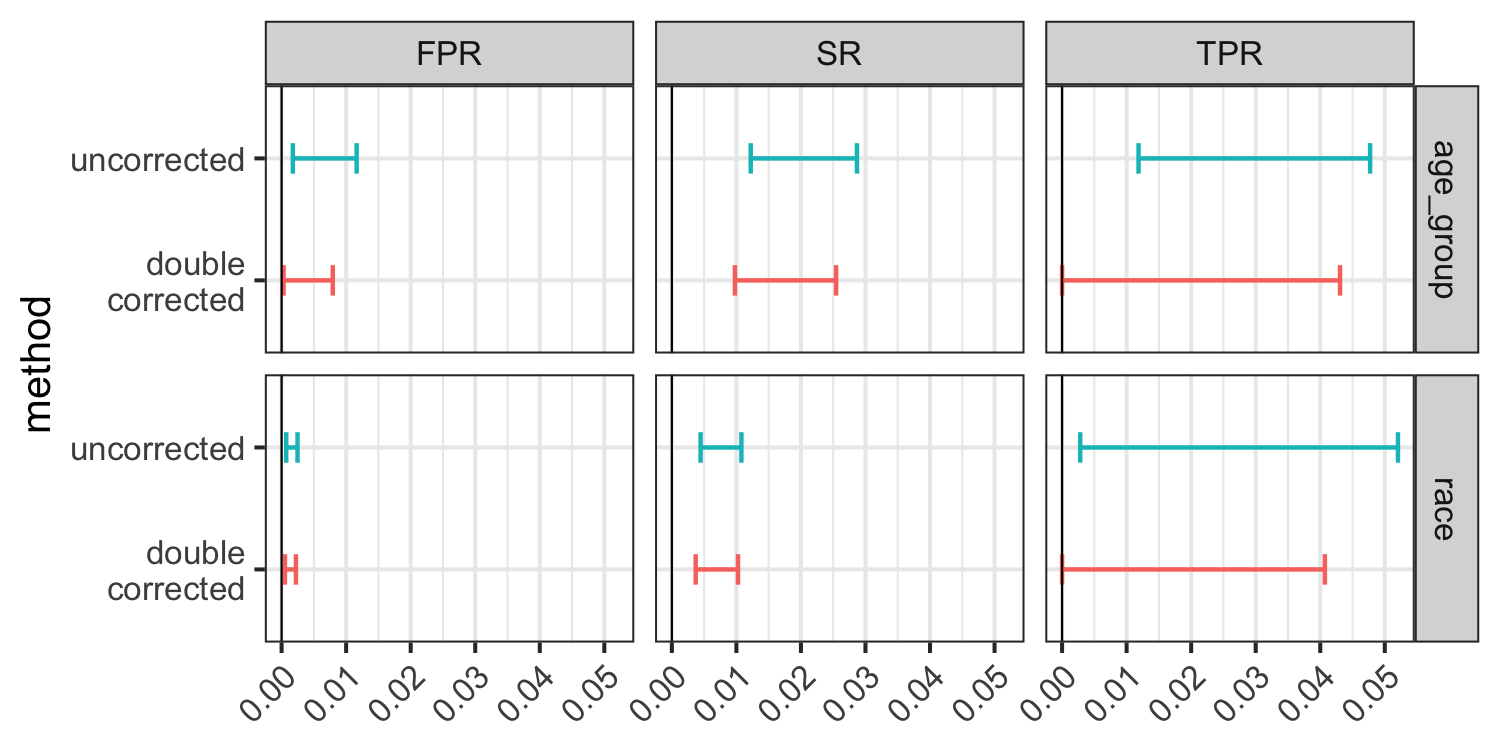

In [14]:
options(repr.plot.width=5, repr.plot.height=2.5, repr.plot.res=300)
ggplot(pd, aes(y=method, color=method, xmax=upper, xmin=lower)) + 
    geom_errorbarh(height=0.25) + 
    geom_vline(xintercept=0, size=0.25) +
    scale_y_discrete(labels=function(x) gsub('_', '\n', x)) +
    facet_grid(feature~metric) + 
    theme_bw(base_size=10) + theme(legend.position='none', axis.text.x=element_text(angle=45, hjust=1))
                     
ggsave("adult_intervals.pdf", width=5, height=2.5)